# Sistem Prediksi Stok Barang dengan Deep Learning

Notebook ini mengimplementasikan sistem prediksi stok yang mempertimbangkan:
1. Data historis stok barang
2. Pola penggunaan dan pergerakan stok
3. Model machine learning berbasis TensorFlow
4. Prediksi barang yang berisiko habis

## Cara Kerja Program

Program akan mengelompokkan status stok menjadi 3 kategori berdasarkan beberapa parameter:

### 1. Status "Berisiko" 
Stok akan ditandai berisiko jika memenuhi salah satu kondisi:
- Stok saat ini = 0 (kosong)
- Estimasi stok habis < 7 hari
- Prediksi model menunjukkan risiko tinggi (> 0.7)
- Stok tersedia < 20% dari rata-rata penggunaan

### 2. Status "Stabil"
Stok dianggap stabil jika:
- Tidak ada pengurangan stok (keluar = 0)
- Masih ada stok tersedia
- Estimasi habis tidak terhitung karena tidak ada pengurangan

### 3. Status "Aman"
Stok dianggap aman jika:
- Tidak termasuk kategori berisiko
- Estimasi stok habis ≥ 7 hari
- Prediksi model menunjukkan risiko rendah
- Stok tersedia > 20% dari rata-rata penggunaan

Proses yang dilakukan:
1. Persiapan dan pembersihan data
2. Feature engineering
3. Pembuatan dan pelatihan model
4. Implementasi sistem prediksi

Kasus penggunaan:
- Memprediksi stok yang kemungkinan akan habis
- Memberikan rekomendasi restock
- Membantu manajemen inventori

# 1. Import Library dan Konfigurasi

## 1.1 Import Library yang Diperlukan
- pandas & numpy: untuk manipulasi data
- tensorflow: untuk membuat dan melatih model neural network
- sklearn: untuk preprocessing data dan evaluasi model
- matplotlib & seaborn: untuk visualisasi data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Data structure example:
"""
{
    'tanggal': date,
    'kode': string,
    'nama_barang': string,
    'stok_awal': int,
    'masuk': int,
    'keluar': int,
    'stok_akhir': int,
    'satuan': string,
    'nilai (Rp)': int,
    'bulan': int
}
"""

"\n{\n    'tanggal': date,\n    'kode': string,\n    'nama_barang': string,\n    'stok_awal': int,\n    'masuk': int,\n    'keluar': int,\n    'stok_akhir': int,\n    'satuan': string,\n    'nilai (Rp)': int,\n    'bulan': int\n}\n"

# 2. Data Loading

## 2.1 Load Dataset
- Membaca file CSV stok
- Mengkonversi kolom tanggal dan waktu ke format yang sesuai
- Mempersiapkan data untuk analisis

Input data yang digunakan:
- tanggal: tanggal pencatatan
- stok_awal: jumlah stok di awal periode
- masuk: jumlah barang masuk
- keluar: jumlah barang keluar
- stok_akhir: jumlah stok di akhir periode
- nilai (Rp): nilai barang
- bulan: bulan pencatatan

In [2]:
# Load stock data
df = pd.read_csv('c:/Users/Asus/OneDrive - student.gunadarma.ac.id/Documents/DICODING/DBS/CAPSTONE/modeling/datasets/[3] clean/stok_bahan_perbulan_sorted.csv')

print("Info Dataset:")
df.info()

print("\nSample Data:")
df.head()

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tanggal      1000 non-null   object
 1   kode         1000 non-null   object
 2   nama_barang  1000 non-null   object
 3   stok_awal    1000 non-null   int64 
 4   masuk        1000 non-null   int64 
 5   keluar       1000 non-null   int64 
 6   stok_akhir   1000 non-null   int64 
 7   satuan       1000 non-null   object
 8   nilai (Rp)   1000 non-null   int64 
 9   bulan        1000 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 78.2+ KB

Sample Data:


,tanggal,kode,nama_barang,stok_awal,masuk,keluar,stok_akhir,satuan,nilai (Rp),bulan
0,2024-01-01 00:00:00,BB0100,Nutrisari,89,31,51,69,sachet,103500,1
1,2024-01-01 00:00:00,BB0125,Beras,39,8,22,25,kg,325000,1
2,2024-01-01 00:00:00,BB0148,Saus Sambal,46,27,35,38,botol,380000,1
3,2024-01-01 00:00:00,BB0767,Kol,65,18,19,64,kg,512000,1
4,2024-01-01 00:00:00,BB0892,Wortel,91,20,61,50,kg,450000,1


# 3. Data Preparation

Melakukan pembersihan data:
1. Mengecek missing values
2. Mengecek dan menangani data duplikat
3. Mengecek distribusi data
4. Feature engineering untuk prediksi

## 3.1 Missing Values Check

In [3]:
# Missing Values Check
print("=== Missing Values Check ===")
print(df.isnull().sum())

=== Missing Values Check ===
tanggal        0
kode           0
nama_barang    0
stok_awal      0
masuk          0
keluar         0
stok_akhir     0
satuan         0
nilai (Rp)     0
bulan          0
dtype: int64


## 3.2 Handle Data Duplicate

In [4]:
print("\n=== Duplicate Check ===")
print(df.duplicated().sum())


=== Duplicate Check ===
0


## 3.3 Mengubah Tipe Data

In [5]:
# Convert time columns to datetime
df['tanggal'] = pd.to_datetime(df['tanggal'])

# Ensure numeric columns are properly typed
numeric_columns = ['stok_awal', 'masuk', 'keluar', 'stok_akhir', 'nilai (Rp)', 'bulan']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tanggal      1000 non-null   datetime64[ns]
 1   kode         1000 non-null   object        
 2   nama_barang  1000 non-null   object        
 3   stok_awal    1000 non-null   int64         
 4   masuk        1000 non-null   int64         
 5   keluar       1000 non-null   int64         
 6   stok_akhir   1000 non-null   int64         
 7   satuan       1000 non-null   object        
 8   nilai (Rp)   1000 non-null   int64         
 9   bulan        1000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 78.2+ KB


## 3.4 Data Distribution


=== Data Distribution ===
         stok_awal        masuk       keluar   stok_akhir    nilai (Rp)  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1.000000e+03   
mean     52.819000    24.984000    38.360000    39.443000  6.454670e+05   
std      27.566904    14.581164    28.870329    28.738034  8.908014e+05   
min       5.000000     0.000000     0.000000     0.000000  0.000000e+00   
25%      29.000000    12.000000    15.000000    15.750000  1.200000e+05   
50%      53.000000    25.000000    32.000000    34.000000  3.720000e+05   
75%      77.000000    38.000000    55.000000    60.000000  8.100000e+05   
max     100.000000    50.000000   137.000000   138.000000  8.640000e+06   

             bulan  
count  1000.000000  
mean      6.489000  
std       3.432442  
min       1.000000  
25%       3.750000  
50%       7.000000  
75%       9.000000  
max      12.000000  
         stok_awal        masuk       keluar   stok_akhir    nilai (Rp)  \
count  1000.000000  1000.000000  

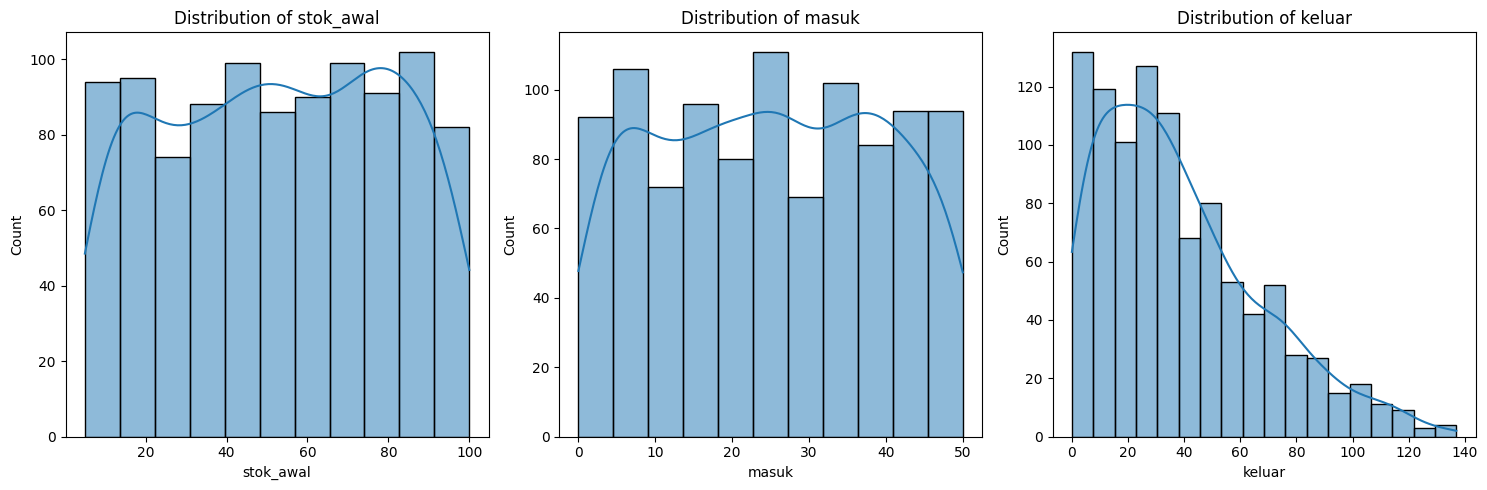

In [6]:
# Analyze distribution of numerical features
print("\n=== Data Distribution ===")
print(df[numeric_columns].describe())

# Visualize distributions
plt.figure(figsize=(15, 5))
for i, col in enumerate(['stok_awal', 'masuk', 'keluar'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## 3.5 Feature Engineering

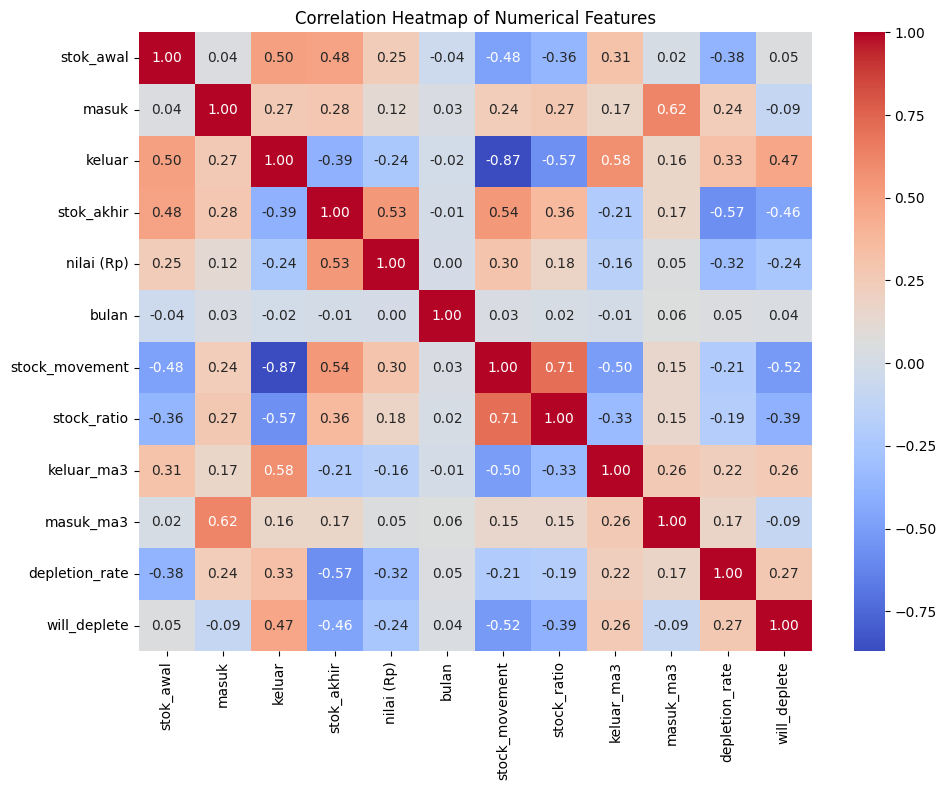

In [7]:
def prepare_features(df):
    # 1. Stock movement features
    df['stock_movement'] = df['masuk'] - df['keluar']
    df['stock_ratio'] = df['stok_akhir'] / df['stok_awal']
    
    # 2. Historical patterns
    df['keluar_ma3'] = df.groupby('nama_barang')['keluar'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['masuk_ma3'] = df.groupby('nama_barang')['masuk'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # 3. Depletion indicators
    df['depletion_rate'] = df['keluar'] / df['stok_awal']
    df['will_deplete'] = (df['stok_akhir'] < df['stok_awal'] * 0.2).astype(int) # Below 20%
    
    return df

# Prepare features
df_prepared = prepare_features(df)

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df_prepared.select_dtypes(include=[np.number]).corr(), 
            annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# 4. Modeling

In [8]:
# Select features for model
features = [
    'stok_awal',
    'masuk',
    'keluar',
    'stock_movement',
    'keluar_ma3',
    'masuk_ma3',
    'depletion_rate',
    'bulan'
]

X = df_prepared[features]
y = df_prepared['will_deplete']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(features),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 224 (896.00 B)

None


In [9]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_acc = 0
        self.best_val_acc = 0
        self.target_reached = False
        
    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        
        # Update best metrics
        self.best_acc = max(self.best_acc, acc)
        self.best_val_acc = max(self.best_val_acc, val_acc)
        
        # Stop jika accuracy dan val_accuracy sudah mencapai target
        if acc >= 0.95 and val_acc >= 0.95 and not self.target_reached:
            print(f"\n\nTarget tercapai pada epoch {epoch + 1}!")
            print(f"Accuracy: {acc:.4f}, Val_accuracy: {val_acc:.4f}\n")
            self.target_reached = True
            self.model.stop_training = True

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5501 - loss: 0.9010 - val_accuracy: 0.7500 - val_loss: 0.6329
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5501 - loss: 0.9010 - val_accuracy: 0.7500 - val_loss: 0.6329
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6147 - loss: 0.7621 - val_accuracy: 0.8938 - val_loss: 0.5785
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6147 - loss: 0.7621 - val_accuracy: 0.8938 - val_loss: 0.5785
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6682 - loss: 0.6678 - val_accuracy: 0.9125 - val_loss: 0.5270
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6682 - loss: 0.6678 - val_accuracy: 0.9125 - val_loss: 0.5270
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6996 - loss: 0.5909 - val_accuracy: 0.9125 - val_loss: 0.4846
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6996 - loss: 0.5909 - val_accuracy: 0.

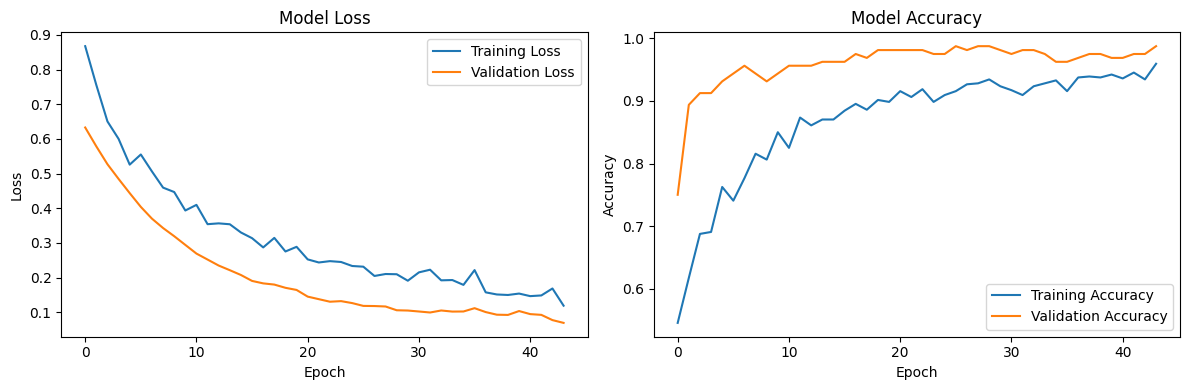

In [10]:
# Training model dengan logging yang lebih baik
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[MyCallback()],
    verbose=1,
)

# Evaluate model
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)


# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 5. Prediction System

In [11]:
def prediksi_stok(nama_barang, stok_awal, masuk, keluar, bulan, historical_data=None):
    """
    Memprediksi risiko kehabisan stok untuk suatu barang
    
    Args:
        nama_barang (str): Nama barang yang akan diprediksi
        stok_awal (int): Jumlah stok awal
        masuk (int): Jumlah barang masuk
        keluar (int): Jumlah barang keluar
        bulan (int): Bulan (1-12)
        historical_data (pd.DataFrame, optional): Data historis untuk perhitungan MA
    """
    # Prepare features
    features = [
        stok_awal,
        masuk,
        keluar,
        masuk - keluar,  # stock_movement
        keluar,  # keluar_ma3 (using current if no historical)
        masuk,   # masuk_ma3 (using current if no historical)
        keluar / stok_awal if stok_awal > 0 else 0,  # depletion_rate
        bulan
    ]
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Make prediction
    prediction = float(model.predict(features_scaled)[0][0])
    
    # Calculate estimated days until depletion
    if keluar > 0:
        days_until_depletion = stok_awal / keluar
    else:
        days_until_depletion = float('inf')
    
    return {
        'nama_barang': nama_barang,
        'probabilitas_habis': prediction,
        'status': 'BERISIKO HABIS ⚠️' if prediction > 0.5 else 'STOK AMAN ✅',
        'estimasi_hari': int(days_until_depletion) if days_until_depletion != float('inf') else 'Tidak terhitung',
        'stok_tersedia': stok_awal,
        'rate_penggunaan': keluar,
        'rekomendasi': 'Perlu restock segera' if prediction > 0.7 else 'Monitor stok'
    }

# 6. Model Saving

In [12]:
# Save model and supporting files
import os
from joblib import dump
import json

# Simpan model dalam format h5
model.save('stok/stok_model.h5')

# Simpan scaler
dump(scaler, 'stok/scaler.joblib')

# Simpan metadata model
model_metadata = {
    'input_shape': [len(features)],
    'features': features,
    'metrics': {
        'train_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy)
    },
    'threshold': 0.5,  # threshold untuk klasifikasi risiko stok
    'preprocessing': {
        'scaler': 'StandardScaler'
    }
}

with open('stok/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("Model dan file pendukung telah disimpan di folder 'stok':")
print("1. stok_model.h5 - Model TensorFlow")
print("2. scaler.joblib - Scaler untuk preprocessing")
print("3. model_metadata.json - Metadata dan informasi model")

print("\nRingkasan Performa Model:")
print(f"Training Accuracy: {model_metadata['metrics']['train_accuracy']:.4f}")
print(f"Testing Accuracy: {model_metadata['metrics']['test_accuracy']:.4f}")

Model dan file pendukung telah disimpan di folder 'stok':
1. stok_model.h5 - Model TensorFlow
2. scaler.joblib - Scaler untuk preprocessing
3. model_metadata.json - Metadata dan informasi model

Ringkasan Performa Model:
Training Accuracy: 0.9800
Testing Accuracy: 0.9850


# 7. Inference

Melakukan uji coba prediksi secara interaktif dengan input dari user. Bagian ini memungkinkan untuk menguji model dengan berbagai skenario input secara langsung.

In [14]:
# Update fungsi prediksi untuk menghasilkan output sesuai tampilan web
def validate_input(nama_barang, stok_awal, masuk, keluar, satuan, bulan):
    """Validates input parameters"""
    if not isinstance(nama_barang, str) or not nama_barang.strip():
        raise ValueError('nama_barang harus berupa string dan tidak boleh kosong')
    if not isinstance(stok_awal, (int, float)) or stok_awal < 0:
        raise ValueError('stok_awal harus berupa angka positif')
    if not isinstance(masuk, (int, float)) or masuk < 0:
        raise ValueError('masuk harus berupa angka positif') 
    if not isinstance(keluar, (int, float)) or keluar < 0:
        raise ValueError('keluar harus berupa angka positif')
    if not isinstance(satuan, str) or not satuan.strip():
        raise ValueError('satuan harus berupa string dan tidak boleh kosong')
    # Clean up satuan input
    satuan = satuan.strip().capitalize()
    if not isinstance(bulan, int) or bulan < 1 or bulan > 12:
        raise ValueError('bulan harus berupa angka 1-12')
    return satuan  # Return cleaned satuan

def prediksi_stok(nama_barang, stok_awal, masuk, keluar, satuan, bulan):
    """
    Memprediksi risiko kehabisan stok untuk suatu barang
    
    Args:
        nama_barang (str): Nama barang yang akan diprediksi
        stok_awal (int): Jumlah stok awal
        masuk (int): Jumlah barang masuk
        keluar (int): Jumlah barang keluar
        satuan (str): Satuan barang (Ekor/Sachet/Kg/dll)
        bulan (int): Bulan (1-12)
    """
    try:
        # Validate and clean inputs
        satuan = validate_input(nama_barang, stok_awal, masuk, keluar, satuan, bulan)
        
        # Prepare features
        features = [
            stok_awal,
            masuk,
            keluar,
            masuk - keluar,  # stock_movement
            keluar,  # keluar_ma3 
            masuk,   # masuk_ma3
            keluar / stok_awal if stok_awal > 0 else 1.0,  # depletion_rate (set to 1.0 if no stock)
            bulan
        ]
        
        # Scale features
        features_scaled = scaler.transform([features])
        
        # Make prediction
        prediction = float(model.predict(features_scaled, verbose=0)[0][0])
        
        # Calculate estimated days until depletion
        if keluar > 0:
            days_until_depletion = max(1, int(np.ceil(stok_awal / keluar)))
        else:
            days_until_depletion = float('inf')
        
        # Adjusted thresholds based on domain knowledge
        # High risk if:
        # 1. No stock currently available OR
        # 2. Less than 7 days of stock remaining OR
        # 3. Model predicts high risk (>0.7) OR
        # 4. Current stock is less than 20% of typical usage
        is_high_risk = (
            stok_awal == 0 or  # No stock is immediate high risk
            (days_until_depletion != float('inf') and days_until_depletion < 7) or
            prediction > 0.7 or
            (stok_awal < keluar * 0.2 if keluar > 0 else False)
        )
        
        # Format output
        return {
            'nama_barang': nama_barang,
            'stok_tersedia': int(stok_awal),
            'satuan': satuan,
            'estimasi_habis': f"{days_until_depletion} Hari" if days_until_depletion != float('inf') else "Stabil",
            'status': 'Berisiko' if is_high_risk else 'Aman'
        }
        
    except Exception as e:
        print(f"Error saat memprediksi stok untuk {nama_barang}: {str(e)}")
        return None

# Improved display function
def print_hasil_prediksi(results):
    # Filter out None results from errors
    valid_results = [r for r in results if r is not None]
    
    print("Status Stok Hari ini:")
    aman = [r for r in valid_results if r['status'].lower() == 'aman']
    beresiko = [r for r in valid_results if r['status'].lower() == 'berisiko']
    
    print(f"🟢 Aman ({len(aman)} items)")
    print(f"🔴 Berisiko ({len(beresiko)} items)\n")
    
    if valid_results:
        print(f"{'Nama Barang':<20} {'Stok Tersedia':<15} {'Satuan':<10} {'Estimasi Habis':<15} {'Status':<10}")
        print("-" * 70)
        
        # Sort by status (Beresiko first) then by estimated days
        sorted_results = sorted(valid_results, 
                               key=lambda x: (x['status'] == 'Aman', 
                                            float('inf') if x['estimasi_habis'] == 'Stabil' 
                                            else int(x['estimasi_habis'].split()[0])))
        
        for r in sorted_results:
            print(f"{r['nama_barang']:<20} {r['stok_tersedia']:<15} {r['satuan']:<10} {r['estimasi_habis']:<15} {r['status']:<10}")
    else:
        print("No valid results to display")

# Test with beberapa barang
test_items = [
    {
        'nama_barang': 'Ikan Nila',
        'stok_awal': 100,
        'masuk': 50,
        'keluar': 30,
        'satuan': 'Ekor',
        'bulan': 6
    },
    {
        'nama_barang': 'Ikan Lele',
        'stok_awal': 50,
        'masuk': 10,
        'keluar': 25,
        'satuan': 'Ekor',
        'bulan': 6
    },
    {
        'nama_barang': 'Ayam Goreng',
        'stok_awal': 1500,
        'masuk': 200,
        'keluar': 100,
        'satuan': 'Ekor',
        'bulan': 6
    },
    {
        'nama_barang': 'Kepala Sapi',
        'stok_awal': 1,
        'masuk': 0,
        'keluar': 1,
        'satuan': 'Ekor',
        'bulan': 6
    },
    {
        'nama_barang': 'Teh',
        'stok_awal': 50,
        'masuk': 50,
        'keluar': 20,
        'satuan': 'Sachet',
        'bulan': 6
    },
    {
        'nama_barang': 'Gula',
        'stok_awal': 100,
        'masuk': 100,
        'keluar': 50,
        'satuan': 'Kg',
        'bulan': 6
    },
    {
        'nama_barang': 'Beras',  
        'stok_awal': 1000,
        'masuk': 500,
        'keluar': 0,
        'satuan': 'Kg',
        'bulan': 6
    },
    {
        'nama_barang': 'Minyak Goreng',  
        'stok_awal': 100,
        'masuk': 50,
        'keluar': 0,
        'satuan': 'Liter',
        'bulan': 6
    }
]

# Run predictions
print("=== Regular Test Cases ===")
results = [prediksi_stok(**item) for item in test_items]
print_hasil_prediksi(results)

=== Regular Test Cases ===


c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, bu

Status Stok Hari ini:
🟢 Aman (3 items)
🔴 Berisiko (5 items)

Nama Barang          Stok Tersedia   Satuan     Estimasi Habis  Status    
----------------------------------------------------------------------
Kepala Sapi          1               Ekor       1 Hari          Berisiko  
Ikan Lele            50              Ekor       2 Hari          Berisiko  
Gula                 100             Kg         2 Hari          Berisiko  
Teh                  50              Sachet     3 Hari          Berisiko  
Ikan Nila            100             Ekor       4 Hari          Berisiko  
Ayam Goreng          1500            Ekor       15 Hari         Aman      
Beras                1000            Kg         Stabil          Aman      
Minyak Goreng        100             Liter      Stabil          Aman      
